In [206]:
%matplotlib inline
from IPython.core.pylabtools import figsize
from IPython.core.display import Image

import numpy as np
import pandas as pd
import iris 
import matplotlib.pyplot as plt
# from mpl_toolkits.basemap import Basemap
import os
import netCDF4 as nc
import datetime as dt

# for working with netcdf files
import xarray as xr
import xarray.ufuncs as xu

# For parallel Computation
import dask
from dask.distributed import Client
import dask.array as da
import dask.dataframe as dd
from dask import delayed
import graphviz

# for reading shapefiles .shp
import shapefile

# for working with polygons
from matplotlib import path
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

# Read in `.nc` file

on the SoGE server: `cdo sellonlatbox,35,46,5,15 africa_chirps_final.nc africa_chirps_final_awash.nc`

In [269]:
data_dir = "/Users/TommyLees/Desktop/chirps_data/africa_chirps_final_141516_awash.nc"
chirps = nc.Dataset(data_dir,'r')
chirps.variables['precip']

<class 'netCDF4._netCDF4.Variable'>
float32 precip(time, latitude, longitude)
    standard_name: convective precipitation rate
    long_name: Climate Hazards group InfraRed Precipitation with Stations
    units: mm/month
    _FillValue: -9999.0
    missing_value: -9999.0
    time_step: month
    geostatial_lat_min: -50.0
    geostatial_lat_max: 50.0
    geostatial_lon_min: -180.0
    geostatial_lon_max: 180.0
unlimited dimensions: time
current shape = (36, 200, 220)
filling on

In [270]:
precip = np.array(chirps.variables['precip'])
lat = np.array(chirps.variables['latitude'])
lon = np.array(chirps.variables['longitude'])
time = np.array(chirps.variables['time'])

# Read in `.shp` file

In [271]:
shp_dir = '/Users/TommyLees/Desktop/chirps_data/awash_analysis/awash_shp/Export_Output.shp'
sf = shapefile.Reader(shp_dir)

In [272]:
bbox = sf.bbox
shape = sf.shapes()[0]
poly_points = shape.points
poly_path = path.Path(poly_points)

# flags = poly_path.contains_points(np.vstack((xx, yy)).T)

# Get precip time_0

In [273]:
# GET PRECIP TIME 0
precip_t = precip[0]
print(precip_t.shape)
# print(precip_t)

(200, 220)


# Create grid of lat, lon points

In [274]:
xmin = lat.min()
ymin = lon.min()
xmax = lat.max()
ymax = lat.max()

In [283]:
# # print(lat.shape)
# # print(lon.shape)

# xx, yy = np.meshgrid(lon, lat)
# # print(xx.shape)
# # print(yy.shape)

# # coordinate_grid = np.array((xx, yy))
# coord_grid = np.array([xx.T.flatten(),yy.T.flatten()]).T
# coord_grid2 = np.array([xx.flatten(),yy.flatten()]).T.reshape(200,220,2)

# # print(np.array(coord_grid).shape)

# coord_grid = coord_grid.reshape(200,220,2)
# # print(coord_grid.shape)
# # print(xx.shape)
# # print(xx.flatten().shape)

# # print(np.array((xx.flatten(), yy.flatten())).shape)

In [285]:
# Sense checking that the shape is correct
print(np.array(coord_grid).reshape(200,220,2).shape) # coordinates of the first pixel
print(np.array(coord_grid).reshape(200,220,2)[0,0,:]) 
print(coord_grid[0,0,:])
print(xx[0], yy[0])

(200, 220, 2)
[35.024994   5.0249977]
[35.024994   5.0249977]
35.024994 5.0249977


In [302]:
# create points (EQUIVALENT METHODS)
xx, yy = np.meshgrid(lon, lat)
xx, yy = xx.flatten(), yy.flatten()
points = np.array((xx, yy)).T
points2 = np.vstack((xx, yy)).T

# print(points.shape)

In [286]:
print(points.shape)
print(points2.shape)

(44000, 2)
(44000, 2)


In [287]:
# so the lat/lon corresponds to the precipitation level at [0,0]
print(coord_grid[0,0])
print(precip_t[0,0])

[35.024994   5.0249977]
3.4451675


# Check if points are inside the shape

In [329]:
flags = poly_path.contains_points(points) # Needs an Nx2 array (...,[x,y])
flags2 = poly_path.contains_points(points2)

In [303]:
print(precip.shape)
print(lat.shape)
print(lon.shape)
print(xx.shape)
print(flags.shape)

(36, 200, 220)
(200,)
(220,)
(44000,)
(44000,)


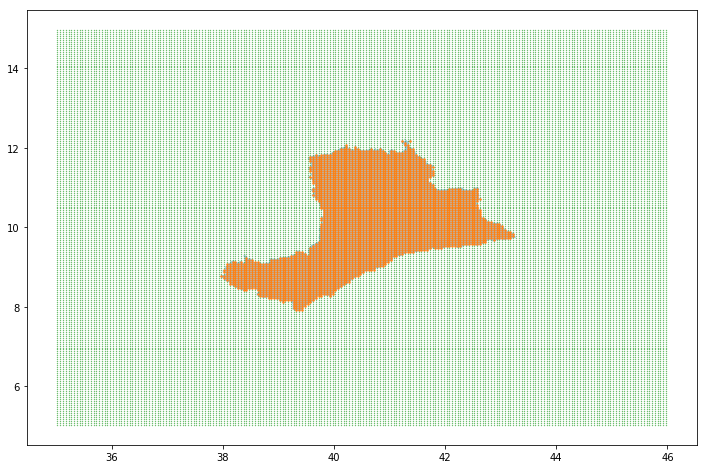

In [312]:
figsize(12,8)
fig,ax = plt.subplots(1,1)

# plot the polygon
p = PatchCollection([Polygon(poly_points)], alpha=0.4)
ax.add_collection(p)

# plot grid points
ax.scatter(xx[flags],yy[flags],2,color="C1") # points INside 
ax.scatter(xx[~flags],yy[~flags],0.1,color="C2") # points OUTside

# # set the bounding box
# ax.set_xlim(xmin-10,xmax+100)
# ax.set_ylim(ymin-10,ymax+100)

In [293]:
# shape(precip)
# shape(lat)
# shape(lon)
# shape(time)
x = np.linspace(xmin,xmax,50)
y = np.linspace(ymin,ymax,50)
xx,yy = np.meshgrid(x,y)
xx,yy = xx.flatten(), yy.flatten()

# Make the mask

#### HOW TO ADD FURTHER CONDITIONS? i.e. masking values of -9999

In [401]:
mask = flags.reshape(200,220)
masked_array = np.ma.array(precip_t, mask=mask)

# HOW TO ADD FURTHER CONDITIONS? i.e. masking values of -9999

In [313]:
points.shape
# 

(44000, 2)

In [314]:
points_grid = points.reshape(200,220,2)

In [315]:
print(points_grid[0,2,:])
print(points[2])

[35.125      5.0249977]
[35.125      5.0249977]


In [330]:
flags.mean() # 8% of the flags are INSIDE the shapefile

0.08545454545454545

In [339]:
mask = flags.reshape(200,220)
print(mask.shape)
print(precip_t.shape)

(200, 220)
(200, 220)


In [433]:
precip_masked = np.ma.array(precip_t, mask=np.logical_or(~mask, precip_t < 0))

In [434]:
precip_t[mask].min()

0.9771135

In [435]:
# precip_masked.argmin()
ma.min(precip_masked)

0.9771135

In [436]:
type(precip_masked)

numpy.ma.core.MaskedArray

In [396]:
ma.where(precip_masked == precip_masked.min())

(array([108, 109, 109, ..., 199, 199, 199]),
 array([191, 186, 187, ..., 155, 156, 157]))

# BUT this has lost all spatial & temporal information! (flat array)

#### HOW TO MASK ALL TIMES? i.e. masking at time 1, 2, 3, 4, 5

##### EVERY 3760 is one timestep (month)

In [383]:
mask = flags.reshape(200,220)

awash_precip = []
for t in range(precip.shape[0]): 
    # for each timestep make a masked array
    awash_precip.append(precip[t,:,:][mask])
    
awash_precip = np.array(awash_precip)
awash_precip_flat = np.array(awash_precip).flatten()

In [417]:
print("mean precip 2014-2016: ",awash_precip_flat.mean())
print("min precip 2014-2016: ",awash_precip_flat.min())
print("max precip 2014-2016: ",awash_precip_flat.max())

print(precip_t[mask].shape)
print(awash_precip_flat.shape)
print(precip.shape[0])
print(awash_precip_flat.shape[0] == (precip_t[mask].shape[0] * precip.shape[0]))

mean precip 2014-2016:  44.92345
min precip 2014-2016:  0.08692829
max precip 2014-2016:  492.47162
(3760,)
(135360,)
36
True


In [398]:
t = 1
precip[t, :, :] = np.ma.array(precip[t, :, :], mask=mask)
precip[t, :, :]

array([[1.4308613e+01, 1.6680372e+01, 1.7975262e+01, ..., 6.9596821e-01,
        6.4188719e-01, 6.4455390e-01],
       [1.4995359e+01, 1.7805796e+01, 2.0940063e+01, ..., 7.3785782e-01,
        6.7598438e-01, 6.5238285e-01],
       [1.7945557e+01, 1.7423468e+01, 1.8724789e+01, ..., 7.7422500e-01,
        7.0290840e-01, 6.4660251e-01],
       ...,
       [5.3896252e-03, 5.9297262e-03, 5.8559328e-03, ..., 5.0892611e+00,
        5.1684270e+00, 5.2572012e+00],
       [7.2593680e-03, 5.5655497e-03, 3.7829576e-03, ..., 5.1036725e+00,
        5.2580090e+00, 5.4221520e+00],
       [4.7739288e-03, 5.1847976e-03, 5.0695129e-03, ..., 5.3816233e+00,
        5.4409137e+00, 5.4982958e+00]], dtype=float32)

# Plot some histograms

/Users/TommyLees/anaconda3/envs/chirps_analysis/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(0, 500)

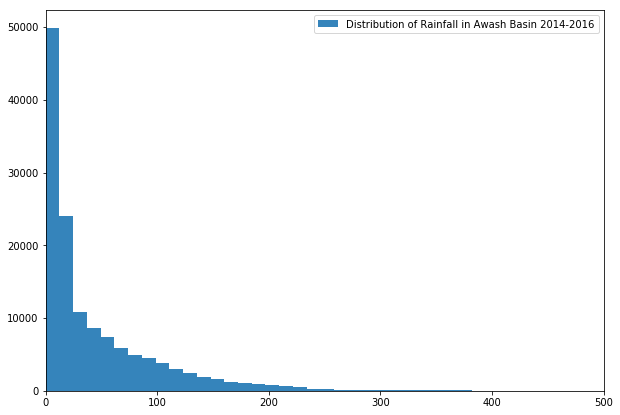

In [418]:
figsize(10,7)
plt.hist(awash_precip_flat, bins=40, normed=False, alpha=0.9, histtype="stepfilled", lw=1, label="Distribution of Rainfall in Awash Basin 2014-2016")
plt.legend(loc="upper right")
plt.xlim(0, 500)

/Users/TommyLees/anaconda3/envs/chirps_analysis/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


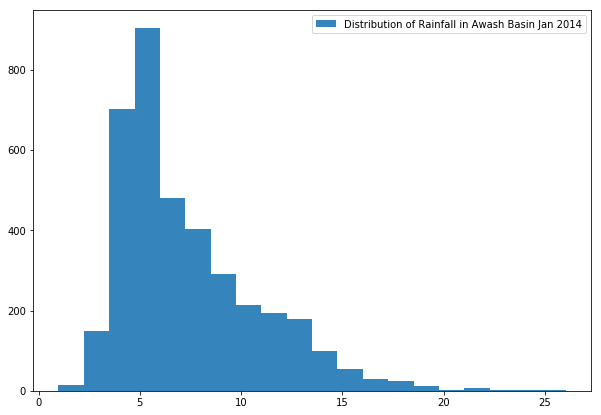

In [432]:
figsize(10,7)
plt.hist(awash_precip[0], bins=20, normed=False, alpha=0.9, histtype="stepfilled", lw=1, label="Distribution of Rainfall in Awash Basin Jan 2014")
plt.legend(loc="upper right")

## Reading to Pandas Dataframe

In [427]:
ds = xr.open_dataset(data_dir)
df = ds.to_dataframe()

In [431]:
df

precip    3.445168
Name: (5.024997711181641, 35.024993896484375, 2014-01-01 00:00:00), dtype: float32

# Read in as numpy arrays

In [3]:
precip = np.array(chirps.variables['precip'])

In [4]:
lon = np.array(chirps.variables['longitude'])
lat = np.array(chirps.variables['latitude'])
time = np.array(chirps.variables['time'])

In [5]:
# precip[precip<0] = numpy.nan
precip = np.ma.masked_where((precip<0), precip)

In [6]:
np.nanmean(precip)

61.984516

In [7]:
precip.mean()

61.98451778901606

# Read in using Dask

In [8]:
client = Client()
client

<Client: scheduler='tcp://127.0.0.1:63465' processes=4 cores=4>

In [9]:
d_chunks = da.from_array(chirps.variables['precip'], chunks=(18,1800,2080))
d_chunks = da.ma.masked_where((d_chunks<0), d_chunks)

In [10]:
avg = d_chunks.mean()

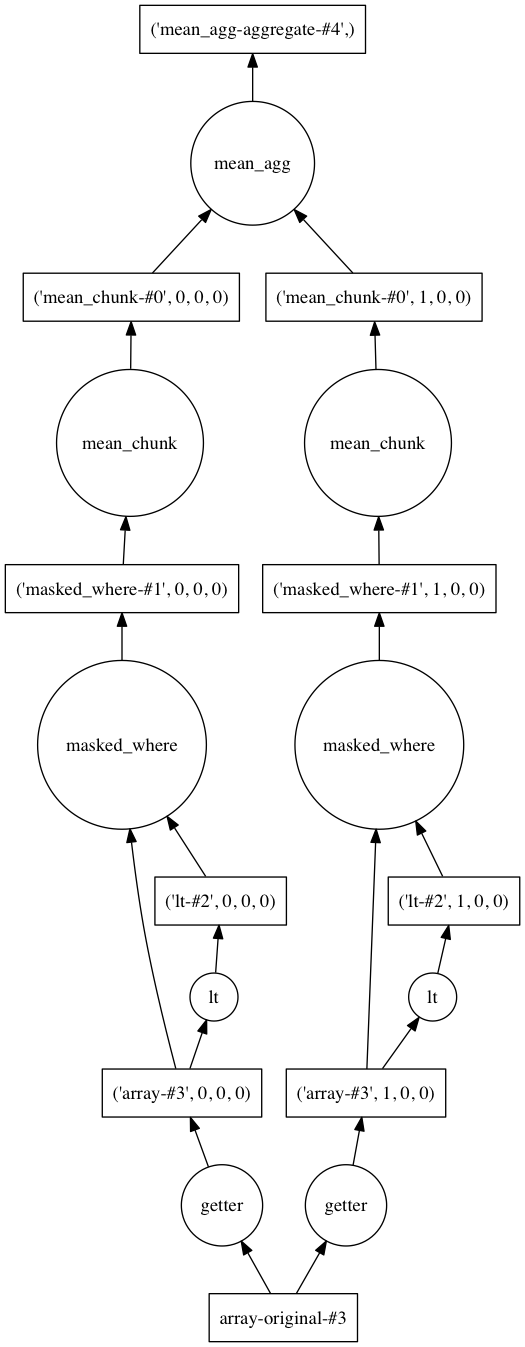

In [11]:
avg.visualize()

In [12]:
%time avg.compute()

CPU times: user 54.8 ms, sys: 46.1 ms, total: 101 ms
Wall time: 334 ms


61.984512

In [13]:
mx = d_chunks.max()
mn = d_chunks.min()

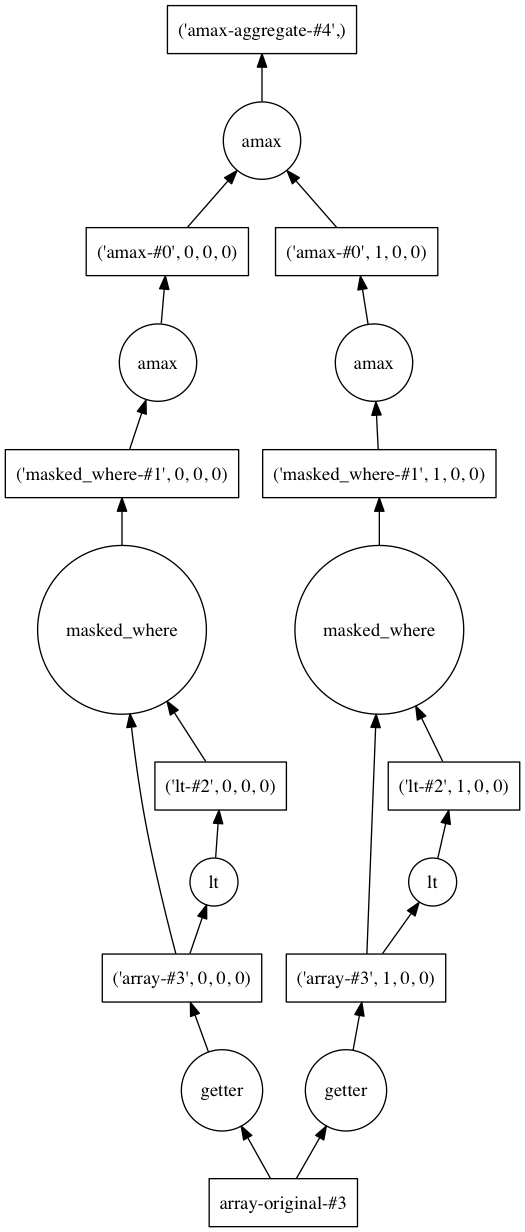

In [14]:
mx.visualize()

In [15]:
%time mx.compute()

CPU times: user 27.7 ms, sys: 15.3 ms, total: 43 ms
Wall time: 58.3 ms


571.47052

In [16]:
%time mn.compute()

CPU times: user 23.6 ms, sys: 12.9 ms, total: 36.5 ms
Wall time: 52.3 ms


0.083568275

In [17]:
%time precip.max()

CPU times: user 2.64 ms, sys: 3.65 ms, total: 6.29 ms
Wall time: 4.18 ms


571.47052

In [18]:
%time precip.min()

CPU times: user 1.01 ms, sys: 370 µs, total: 1.38 ms
Wall time: 953 µs


0.083568275

# Read in using xarray

In [28]:
# dataset = nc.Dataset(data_dir,'r')
dataset = xr.open_dataset(data_dir, chunks={'latitude':100, 'longitude':100})
dataset.attrs = {} # hide the output of the attributes

In [20]:
dataset

<xarray.Dataset>
Dimensions:    (latitude: 1800, longitude: 2080, time: 36)
Coordinates:
  * longitude  (longitude) float32 -27.975 -27.925 -27.875 -27.825 -27.775 ...
  * latitude   (latitude) float32 -41.975 -41.925 -41.875 -41.825 -41.775 ...
  * time       (time) datetime64[ns] 2014-01-01 2014-02-01 2014-03-01 ...
Data variables:
    precip     (time, latitude, longitude) float32 dask.array<shape=(36, 1800, 2080), chunksize=(36, 100, 100)>

In [21]:
print(dataset.longitude.attrs)
print(dataset.latitude.attrs)

OrderedDict([('standard_name', 'longitude'), ('long_name', 'longitude'), ('units', 'degrees_east'), ('axis', 'X')])
OrderedDict([('standard_name', 'latitude'), ('long_name', 'latitude'), ('units', 'degrees_north'), ('axis', 'Y')])


In [22]:
# N.B. Dask arrays for parallel computation
dataset.precip

<xarray.DataArray 'precip' (time: 36, latitude: 1800, longitude: 2080)>
dask.array<shape=(36, 1800, 2080), dtype=float32, chunksize=(36, 100, 100)>
Coordinates:
  * longitude  (longitude) float32 -27.975 -27.925 -27.875 -27.825 -27.775 ...
  * latitude   (latitude) float32 -41.975 -41.925 -41.875 -41.825 -41.775 ...
  * time       (time) datetime64[ns] 2014-01-01 2014-02-01 2014-03-01 ...
Attributes:
    standard_name:       convective precipitation rate
    long_name:           Climate Hazards group InfraRed Precipitation with St...
    units:               mm/month
    time_step:           month
    geostatial_lat_min:  -50.0
    geostatial_lat_max:  50.0
    geostatial_lon_min:  -180.0
    geostatial_lon_max:  180.0

In [23]:
# View the chunk sizes
dataset.chunks

Frozen(SortedKeysDict({'time': (36,), 'latitude': (100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100), 'longitude': (100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 80)}))

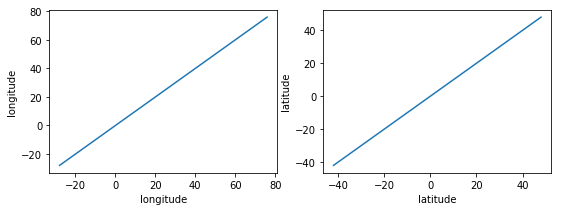

In [24]:
figsize(9, 3)
fig, (ax1,ax2) = plt.subplots(ncols=2)
dataset.longitude.plot(ax=ax1)
dataset.latitude.plot(ax=ax2)

In [25]:
dataset.precip.shape

(36, 1800, 2080)

CPU times: user 4.57 s, sys: 1.42 s, total: 5.99 s
Wall time: 9.31 s


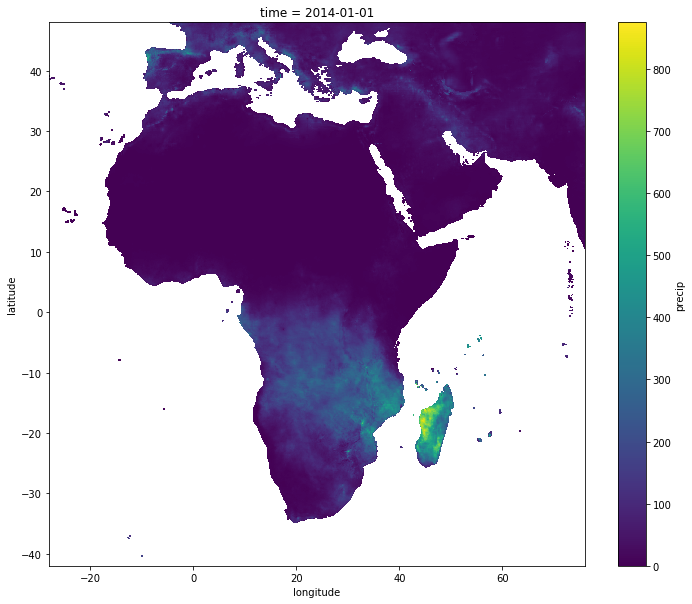

In [26]:
figsize(12, 10)
%time dataset.precip[0].plot()
ax_list = fig.axes

## What structure does the precip data have?
- mm / month
- 432 months
- 1,617,408,000 precip readings

In [71]:
dataset.precip

<xarray.DataArray 'precip' (time: 36, latitude: 1800, longitude: 2080)>
dask.array<shape=(36, 1800, 2080), dtype=float32, chunksize=(36, 100, 100)>
Coordinates:
  * longitude  (longitude) float32 -27.975 -27.925 -27.875 -27.825 -27.775 ...
  * latitude   (latitude) float32 -41.975 -41.925 -41.875 -41.825 -41.775 ...
  * time       (time) datetime64[ns] 2014-01-01 2014-02-01 2014-03-01 ...
Attributes:
    standard_name:       convective precipitation rate
    long_name:           Climate Hazards group InfraRed Precipitation with St...
    units:               mm/month
    time_step:           month
    geostatial_lat_min:  -50.0
    geostatial_lat_max:  50.0
    geostatial_lon_min:  -180.0
    geostatial_lon_max:  180.0

In [72]:
size(dataset.precip.data) == 432 * 1800 * 2080

False

In [73]:
type(dataset.data_vars)
# dataset.coords
# dataset.dims
# dataset.attrs

xarray.core.dataset.DataVariables

## Calculate the monthly means (climatology)

In [48]:
mon_average = dataset.resample(time='1MS').mean()

In [49]:
size(mon_average.precip.data)

134784000

In [193]:
dataset.precip.resample('MS', dim='time')

/Users/TommyLees/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="MS").mean() 
  """Entry point for launching an IPython kernel.


<xarray.DataArray 'precip' (time: 432, latitude: 1800, longitude: 2080)>
dask.array<shape=(432, 1800, 2080), dtype=float32, chunksize=(1, 1800, 2080)>
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01 1981-02-01 1981-03-01 ...
  * latitude   (latitude) float32 -41.975 -41.925 -41.875 -41.825 -41.775 ...
  * longitude  (longitude) float32 -27.975 -27.925 -27.875 -27.825 -27.775 ...

## Using groupby functionality

In [93]:
ds_by_month = dataset.groupby('time.month').mean('time')
anomalies = dataset.groupby('time.month') - ds_by_month

In [94]:
# What are the groups?
print(dataset.groupby('time.month').groups)

{1: [0, 12, 24], 2: [1, 13, 25], 3: [2, 14, 26], 4: [3, 15, 27], 5: [4, 16, 28], 6: [5, 17, 29], 7: [6, 18, 30], 8: [7, 19, 31], 9: [8, 20, 32], 10: [9, 21, 33], 11: [10, 22, 34], 12: [11, 23, 35]}


In [95]:
# Has our monmean been computed correctly?
ds_by_month.precip.shape

(12, 1800, 2080)

In [92]:
# TAKES A LONG TIME TO COMPUTE (loads into memory?)
# figsize(12, 10)
# %time ds_by_month.precip[0].plot()

In [ ]:
# Ensemble- and time-averaged.
calCS = ds['FG_CO2'].sel(nlat=slice(a, b), nlon=slice(c, d))
calMean = calCS.mean(dim='ensemble').mean(dim='time')

In [79]:
# Get the mean precipitation for months

%time for i in range(12):
    df = ds_by_month.precip[i].mean().to_pandas()
    

/Users/TommyLees/anaconda3/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CPU times: user 4.43 s, sys: 57.1 s, total: 1min 1s
Wall time: 1min 10s


Object `find_indices` not found.


## Compute by collapsing lat/long

In [54]:
stacked = ds_by_month.stack(allpoints=['latitude','longitude'])

In [55]:
# takes time to run
# !!!!!!!!!!!!!!!!!
%time global_mon_mean = stacked.groupby('allpoints').mean()

KeyboardInterrupt: 

In [181]:
%time stacked.groupby('allpoints').mean().to_netcdf('monmean.nc')

In [184]:
def extract_means():
    means = {}
    for i in range(12):
        means[i] = ds_by_month.precip[0].mean()
    return means

%time extract_means()

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 42 µs


<function extract_means at 0x218bc1b70>

47.554497

In [86]:
# # TAKES A LONG TIME TO COMPUTE
# %time result = ds_by_month.precip.load()

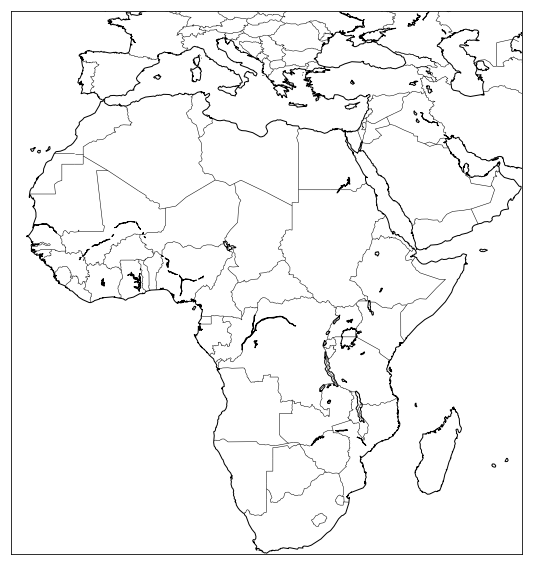

In [77]:
figsize(12, 10)
fig,ax = plt.subplots()
map = Basemap(llcrnrlon=-20, llcrnrlat=-35, urcrnrlon=60, urcrnrlat=50, projection='cyl', resolution='l')
map.drawcoastlines()
map.drawcountries()

## Using the netCDF4 Package

In [6]:
dataset = nc.Dataset(data_dir, 'r')

In [7]:
lat = np.asarray(dataset.variables['latitude'])
lon = np.asarray(dataset.variables['longitude'])
time = np.asarray(dataset.variables['time'])

In [9]:
# WILL TAKE FOREVER
# precip = np.asarray(dataset.variables['time'])

In [10]:
dataset.close()

## Using the Iris package

In [56]:
iris_data = iris.load_cube(data_dir)

/Users/TommyLees/anaconda3/lib/python3.6/site-packages/iris/fileformats/cf.py:1143: IrisDeprecation: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warn_deprecated(msg)


In [57]:
print(iris_data)

Climate Hazards group InfraRed Precipitation with Stations / (mm/month) (time: 36; latitude: 1800; longitude: 2080)
     Dimension coordinates:
          time                                                               x             -                -
          latitude                                                           -             x                -
          longitude                                                          -             -                x
     Attributes:
          CDI: Climate Data Interface version ?? (http://mpimet.mpg.de/cdi)
          CDO: Climate Data Operators version 1.7.0 (http://mpimet.mpg.de/cdo)
          Conventions: CF-1.6
          acknowledgements: The Climate Hazards Group InfraRed Precipitation with Stations development...
          comments:  time variable denotes the first day of the given month.
          creator_email: pete@geog.ucsb.edu
          creator_name: Pete Peterson
          date_created: 2018-01-17
          documentation:

In [104]:
import iris.coord_categorisation as coord_cat

coord_cat.add_month(iris_data, 'time', name="month")

In [ ]:
# # WARNING: Takes a very long time to compute
# mon_mean = iris_data.aggregated_by('month', iris.analysis.MEAN)